In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torchvision import models, transforms
import torch
import os
import cv2
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
import random
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import GridSearchCV

In [2]:
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
data_dir = "C:\\Users\\14385\\Desktop\\MaskRCNN'"
all_files = [f for f in os.listdir(data_dir)]
print(len(all_files))

167


**Mask R CNN has  been applied to the data set in order to remove the background.**

# Pre-Processing

**Data Augmentation**

In [4]:
preprocess_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# **Visualizing Original VS Augmented**

In [5]:
random_files = random.sample(all_files, 8)
random_image_paths = [os.path.join(data_dir, filename) for filename in random_files]

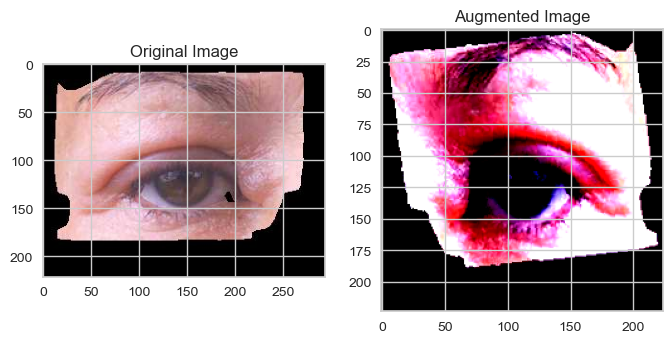

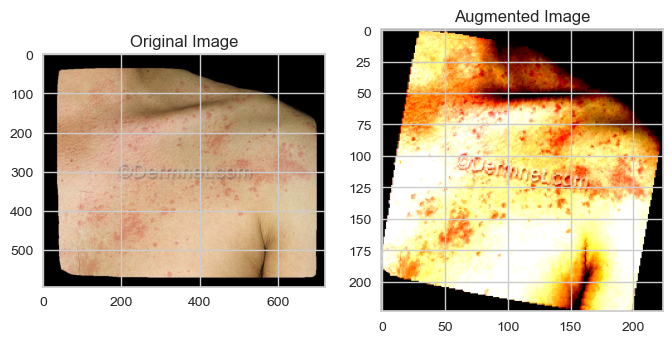

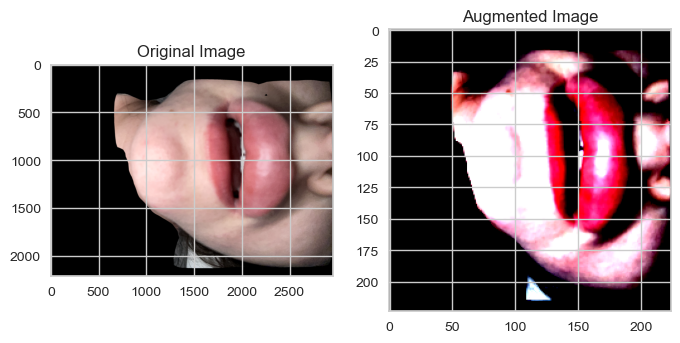

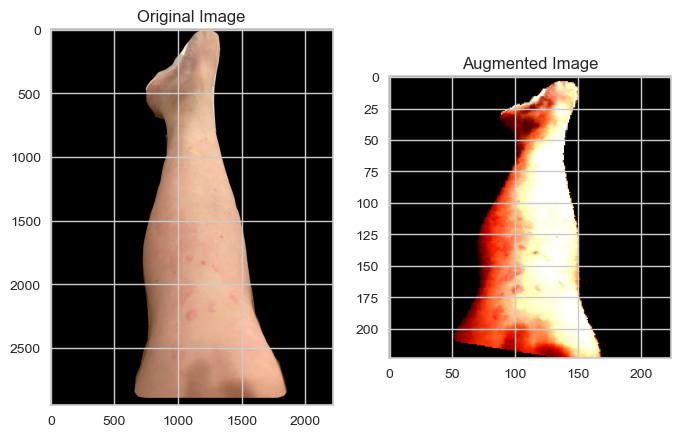

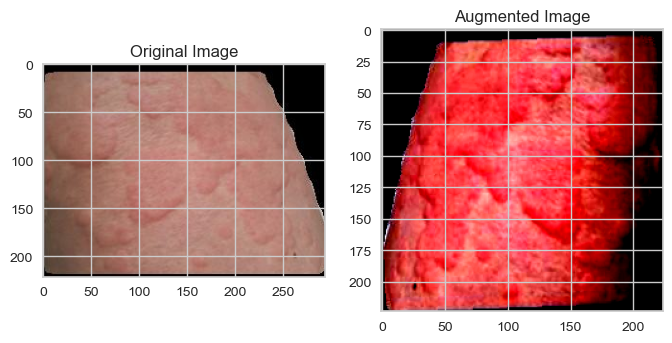

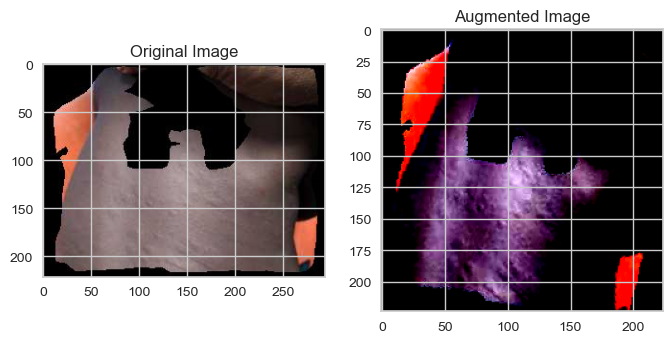

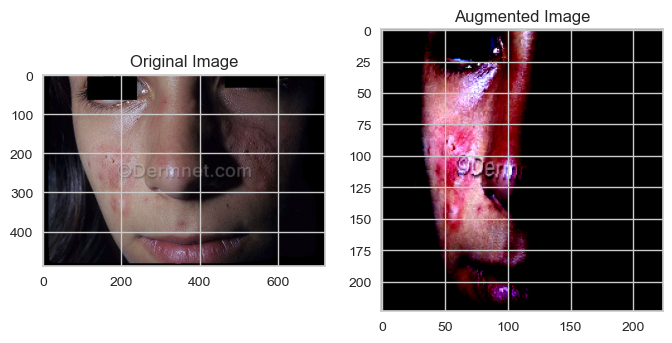

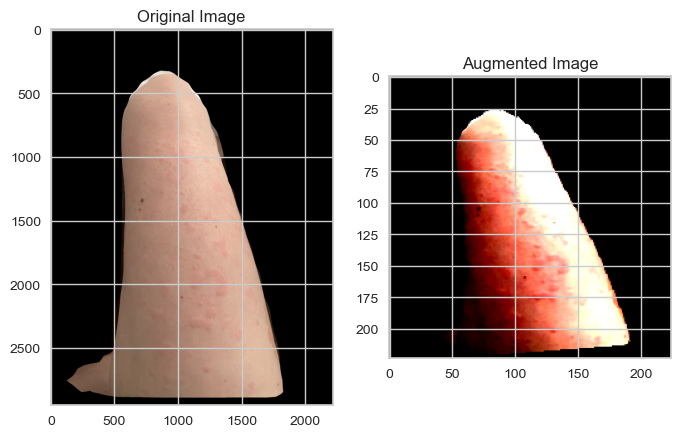

In [6]:
for image_path in random_image_paths:
    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    # Apply data augmentation and display the augmented image
    augmented_image = preprocess_transform(original_image)
    augmented_image = augmented_image.permute(1, 2, 0).numpy()  # Change tensor to numpy array
    augmented_image = np.clip(augmented_image, 0, 1)
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title("Augmented Image")

    plt.show()

# CNN: AlexNet

In [7]:
model = models.alexnet(pretrained=True)
model.eval()

C:\Users\14385\anaconda3\envs\py311\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\14385\anaconda3\envs\py311\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Feature Extraction 

In [8]:
def extract_features_cnn(image_path, preprocess_transform):
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply PyTorch transform
        img_tensor = preprocess_transform(img)
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

    except Exception as e:
        return None

    if img_tensor is None:
        return None

    with torch.no_grad():
        features = model(img_tensor)

    features = features.view(features.size(0), -1).detach().cpu().numpy()

    return features

In [9]:
all_features = [extract_features_cnn(os.path.join(data_dir, filename), preprocess_transform) for filename in all_files if extract_features_cnn(os.path.join(data_dir, filename), preprocess_transform) is not None]

In [10]:
features_length = len(all_features)

# Print the length
print("Number of features:", features_length)

Number of features: 167


In [11]:
#Checking shape
image_index = 0 
features_for_image = all_features[image_index]

print(f"Type of features: {type(features_for_image)}")
print(f"Shape of features: {features_for_image.shape}")


Type of features: <class 'numpy.ndarray'>
Shape of features: (1, 1000)


# Visualizing Images After Feature Extraction:

In [12]:
print(all_features)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Converting List of Features into a 2D Array

In [13]:
all_features_array = np.vstack([feature for feature in all_features if feature is not None])

# Scalling 

In [14]:
scaler = StandardScaler()
all_features_standardized = scaler.fit_transform(all_features_array)

# PCA

In [15]:
pca = PCA(n_components=5)
reduced_features = pca.fit_transform(all_features_standardized)

In [16]:
print("Explained variance ratio after PCA:", pca.explained_variance_ratio_)


Explained variance ratio after PCA: [0.16728945 0.1490109  0.08160665 0.0723535  0.05905515]


In [17]:
singular_values = print(pca.singular_values_)

[167.14467 157.74924 116.74036 109.92286  99.30866]


In [18]:
np.sum(pca.explained_variance_ratio_)

0.52931565

In [19]:
pca.components_[0]

array([-5.42044267e-02, -7.06816744e-03, -3.20287198e-02, -2.05197278e-02,
       -1.88143644e-02,  1.82400569e-02,  1.29992124e-02, -2.77505647e-02,
        8.16985685e-03,  3.76633257e-02,  1.64614599e-02,  3.68644558e-02,
        5.74103706e-02,  2.58944277e-02,  2.81558884e-03,  5.38768731e-02,
        3.70257087e-02,  1.67429224e-02,  4.99167778e-02,  2.79558897e-02,
       -7.25831138e-03,  2.25786194e-02,  3.22313346e-02,  3.31980474e-02,
       -1.31836524e-02, -2.66996752e-02, -6.40715798e-03, -2.29420178e-02,
       -5.17431237e-02,  1.86162535e-03, -3.91709246e-02, -6.60344772e-03,
       -4.64856774e-02, -2.92680133e-02, -3.00462879e-02,  1.77466385e-02,
       -3.68563309e-02, -3.58892344e-02,  3.34647228e-03, -1.50742279e-02,
        6.82805199e-03, -1.94144193e-02,  7.51017407e-03, -3.00645940e-02,
        7.03091826e-03, -4.85756621e-03,  2.68558320e-02, -8.95574875e-03,
       -7.89509434e-03, -2.06108987e-02, -3.14626768e-02,  2.69521829e-02,
       -2.38999426e-02, -

In [20]:
len(pca.components_[0])

1000

# Clustering: HIERARCHICAL 


In [21]:
num_clusters = 3
clustering = AgglomerativeClustering(n_clusters=num_clusters)
cluster_labels_h = clustering.fit_predict(reduced_features)

In [22]:
df_h = pd.DataFrame({
    'X': reduced_features[:, 0],
    'Y': reduced_features[:, 1],
    'Cluster': cluster_labels_h
})

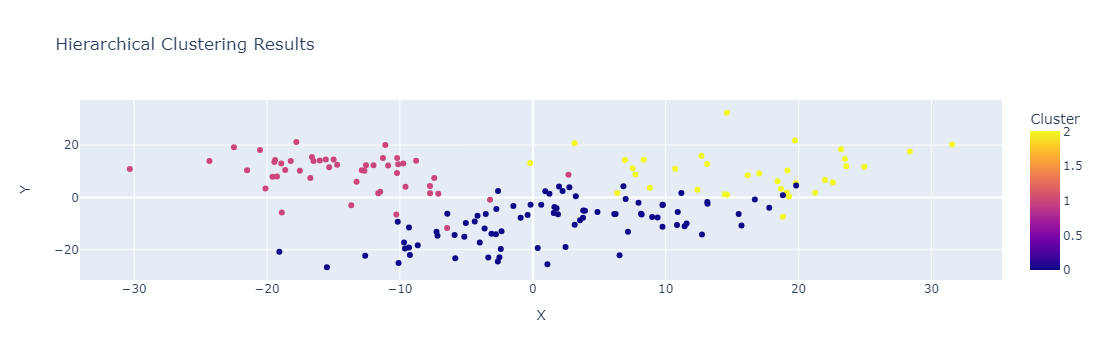

In [23]:
fig = px.scatter(df_h, x='X', y='Y', color='Cluster', title='Hierarchical Clustering Results', labels={'Cluster': 'Cluster'})
fig.show()

In [24]:
unique_clusters = np.unique(cluster_labels_h)
num_clusters = len(unique_clusters)
print("Number of clusters found by Hierarchical:", num_clusters)

Number of clusters found by Hierarchical: 3


# Urticaria Images

In [25]:
image_paths = [os.path.join(data_dir, filename) for filename in all_files]

cluster_images = {cluster: [] for cluster in range(num_clusters)}
for i, image_path in enumerate(image_paths):
    cluster_images[cluster_labels_h[i]].append(image_path)

# Print the number of samples in each cluster
unique_clusters, counts = np.unique(cluster_labels_h, return_counts=True)
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} samples")

# Print out the images for each cluster
for cluster, images in cluster_images.items():
    print(f"\nImages in Cluster {cluster}:")
    for image in images:
        print(image)


Cluster 0: 84 samples
Cluster 1: 49 samples
Cluster 2: 34 samples

Images in Cluster 0:
C:\Users\14385\Desktop\MaskRCNN'\segmented_AllergyK_Vibratory01.png.png
C:\Users\14385\Desktop\MaskRCNN'\segmented_AllergyK_Vibratory02.png.png
C:\Users\14385\Desktop\MaskRCNN'\segmented_angioedema-0011__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
C:\Users\14385\Desktop\MaskRCNN'\segmented_angioedema-0012__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
C:\Users\14385\Desktop\MaskRCNN'\segmented_angioedema-0016__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
C:\Users\14385\Desktop\MaskRCNN'\segmented_angioedema-0017__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
C:\Users\14385\Desktop\MaskRCNN'\segmented_DermnetNZ_Aguagenic01.png.jpg
C:\Users\14385\Desktop\MaskRCNN'\segmented_DermnetNZ_Cold02.png.jpg
C:\Users\14385\Desktop\MaskRCNN'\segmented_DermnetNZ_Cold03.png.jpg
C:\Users\14385\Desktop\MaskRCNN'\segmented_DermnetNZ_Pressure02.png.jpg
C:\Users\14385\Desk

In [26]:
print("Original feature shape:", np.vstack(all_features).shape)
print("Standardized feature shape:", all_features_standardized.shape)

Original feature shape: (167, 1000)
Standardized feature shape: (167, 1000)


# Gaussian Mixture CLustering

In [27]:
image_names = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

gmm = GaussianMixture(n_components=3, random_state=42) 
gmm_cluster_labels = gmm.fit_predict(reduced_features)

if len(image_names) != len(gmm_cluster_labels):
    raise ValueError("Lengths of 'image_names' and 'gmm_cluster_labels' must be the same")
    
df_gmm_ = pd.DataFrame({'Image': image_names, 'Cluster': gmm_cluster_labels})
print(df_gmm_)

C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



ValueError: Lengths of 'image_names' and 'gmm_cluster_labels' must be the same

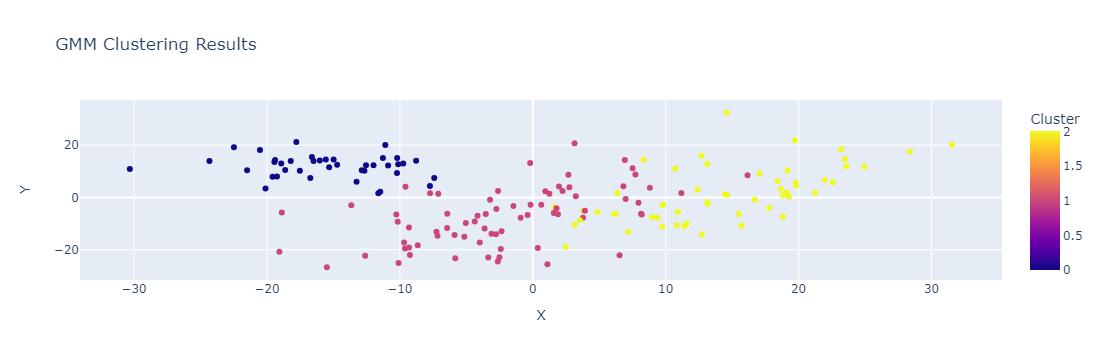

In [28]:
df_gmm = pd.DataFrame({
    'X': reduced_features[:, 0],
    'Y': reduced_features[:, 1],
    'Cluster': gmm_cluster_labels 
})

fig = px.scatter(df_gmm, x='X', y='Y', color='Cluster', title='GMM Clustering Results')
fig.show()

In [29]:
# Print out the names of the images for each cluster
for cluster, images in cluster_images.items():
    print(f"\nImages in Cluster {cluster}:")
    for image in images:
        print(os.path.basename(image))


Images in Cluster 0:
segmented_AllergyK_Vibratory01.png.png
segmented_AllergyK_Vibratory02.png.png
segmented_angioedema-0011__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
segmented_angioedema-0012__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
segmented_angioedema-0016__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
segmented_angioedema-0017__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg
segmented_DermnetNZ_Aguagenic01.png.jpg
segmented_DermnetNZ_Cold02.png.jpg
segmented_DermnetNZ_Cold03.png.jpg
segmented_DermnetNZ_Pressure02.png.jpg
segmented_DermnetNZ_Pressure03.png.jpg
segmented_DermnetNZ_Solar01.png.jpg
segmented_DermnetNZ_Urticaria_Unlabeled01.png.jpg
segmented_DermnetNZ_Urticaria_Unlabeled03.png.jpg
segmented_DermnetNZ_Urticaria_Unlabeled07.png.jpg
segmented_DermnetNZ_Urticaria_Unlabeled08.png.jpg
segmented_DermnetNZ_Urticaria_Unlabeled09.png.jpg
segmented_DermnetNZ_Urticaria_Unlabeled10.png.jpg
segmented_DermnetNZ_Urticaria_Unlabeled1

In [30]:
# Print the number of samples in each cluster for GMM
unique_clusters, counts = np.unique(gmm_cluster_labels, return_counts=True)
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} samples")
print(len(gmm_cluster_labels))

Cluster 0: 40 samples
Cluster 1: 73 samples
Cluster 2: 54 samples
167


# K - Means Clustering:

In [31]:

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_cluster_labels = kmeans.fit_predict(reduced_features)
print("K-Means Cluster Labels:", kmeans_cluster_labels)


C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



K-Means Cluster Labels: [1 2 1 2 2 2 2 0 2 1 2 2 1 1 1 1 1 0 2 2 0 1 2 1 1 1 1 1 1 1 2 2 2 1 2 2 2
 1 1 2 2 2 2 2 2 2 1 1 1 1 2 2 1 1 1 2 0 2 2 2 1 2 2 2 2 1 1 2 2 1 1 2 2 2
 0 2 1 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 1 2 1 2 2 2 2 0 0
 0 0 0 2 0 1 2 2 1 1 1 2 2 2 2 2 2 1 0 2 2 2 0 2 2 2 2 2 0 2 1 1 2 2 1 2 0
 0 2 2 0 0 0 0 2 0 0 0 0 2 1 2 0 2 1 2]


In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


# Grid Search

In [34]:
from sklearn.metrics import silhouette_score
param_grid = {'n_clusters': range(2, 11)}
# Perform grid search without specifying scoring
grid_search = GridSearchCV(kmeans, param_grid, cv=5)

# Fit to data
grid_search.fit(reduced_features)

# Get the best hyperparameters
best_params = grid_search.best_params_

best_num_clusters = best_params['n_clusters']

# Use the best model to predict cluster labels
best_kmeans = grid_search.best_estimator_
best_kmeans_cluster_labels = best_kmeans.predict(reduced_features)

# Calculate Silhouette Score separately
silhouette_avg_gs = silhouette_score(reduced_features, best_kmeans_cluster_labels)
print("Best Number of Clusters:", best_num_clusters)
print("Best Silhouette Score:", silhouette_avg_gs)


C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Window

Best Number of Clusters: 10
Best Silhouette Score: 0.21736762


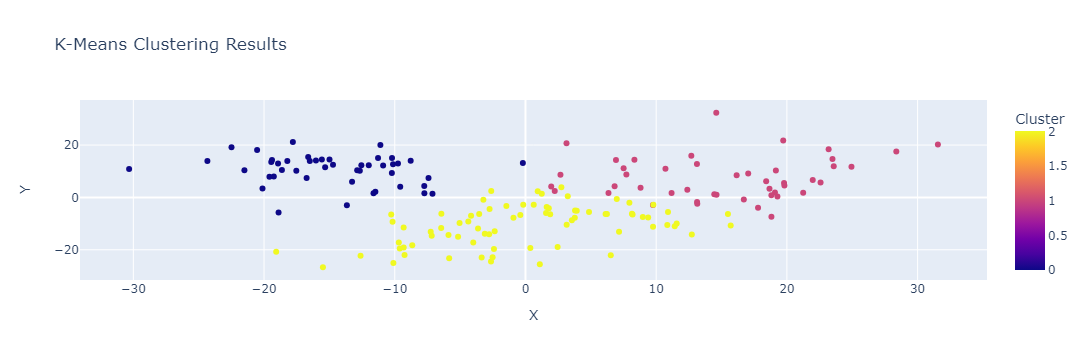

In [35]:
df_kmeans = pd.DataFrame({
    'X': reduced_features[:, 0],
    'Y': reduced_features[:, 1],
    'Cluster': kmeans_cluster_labels
})

fig = px.scatter(df_kmeans, x='X', y='Y', color='Cluster', title='K-Means Clustering Results')
fig.show()

In [36]:
unique_clusters, counts = np.unique(kmeans_cluster_labels, return_counts=True)
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} samples")
print(len(kmeans_cluster_labels))

Cluster 0: 46 samples
Cluster 1: 45 samples
Cluster 2: 76 samples
167


In [37]:
pip install yellowbrick


Note: you may need to restart the kernel to use updated packages.


**Elbow - K Means**

C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\14385\anaconda3\envs\py311\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environ

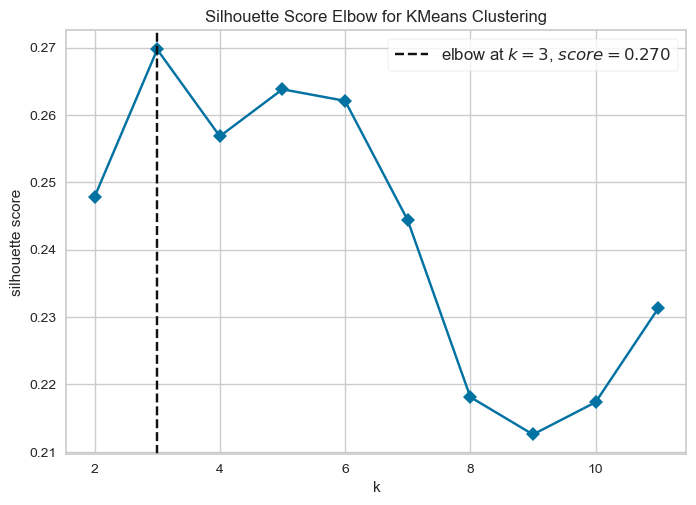

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [38]:
model_KMeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(model_KMeans, k=(2, 12), metric='silhouette', timings=False)

visualizer.fit(reduced_features)
visualizer.show()

# y 

# Metrics:

**Silhouette Score from -1 to 1**

In [39]:
silhouette_avg_h = silhouette_score(reduced_features, cluster_labels_h)
silhouette_avg_gmm = silhouette_score(reduced_features, gmm_cluster_labels)
silhouette_avg_kmeans = silhouette_score(reduced_features, kmeans_cluster_labels)

print(f"Silhouette Score Hierarchical: {silhouette_avg_h}")
print(f"Silhouette Score Gaussian MM: {silhouette_avg_gmm}")
print(f"Silhouette Score K-Means: {silhouette_avg_kmeans}")

Silhouette Score Hierarchical: 0.255777508020401
Silhouette Score Gaussian MM: 0.2270011454820633
Silhouette Score K-Means: 0.269736111164093


**Davies-Bouldin Index has no specified range, and lower values are better :**

In [40]:
db_index_h = davies_bouldin_score(reduced_features, cluster_labels_h)
db_index_gmm = davies_bouldin_score(reduced_features, gmm_cluster_labels)
db_index_kmeans = davies_bouldin_score(reduced_features, kmeans_cluster_labels)
print(f"Davies-Bouldin Index Hierarchical: {db_index_h}")
print(f"Davies-Bouldin Index GMM: {db_index_gmm}")
print(f"Davies-Bouldin Index K-Means: {db_index_kmeans}")


Davies-Bouldin Index Hierarchical: 1.3763781641663677
Davies-Bouldin Index GMM: 1.6566202739276612
Davies-Bouldin Index K-Means: 1.3697066374765743


**Calinski-Harabasz Index has no specific range, and higher values are better.**

In [41]:
ch_index_h = calinski_harabasz_score(reduced_features, cluster_labels_h)
ch_index_gmm = calinski_harabasz_score(reduced_features, gmm_cluster_labels)
ch_index_kmeans = calinski_harabasz_score(reduced_features, kmeans_cluster_labels)
print(f"Calinski-Harabasz Index: {ch_index_h}")
print(f"Calinski-Harabasz Index: {ch_index_gmm}")
print(f"Calinski-Harabasz Index: {ch_index_kmeans}")

Calinski-Harabasz Index: 54.00765262455906
Calinski-Harabasz Index: 48.05625854684359
Calinski-Harabasz Index: 59.47476917062094


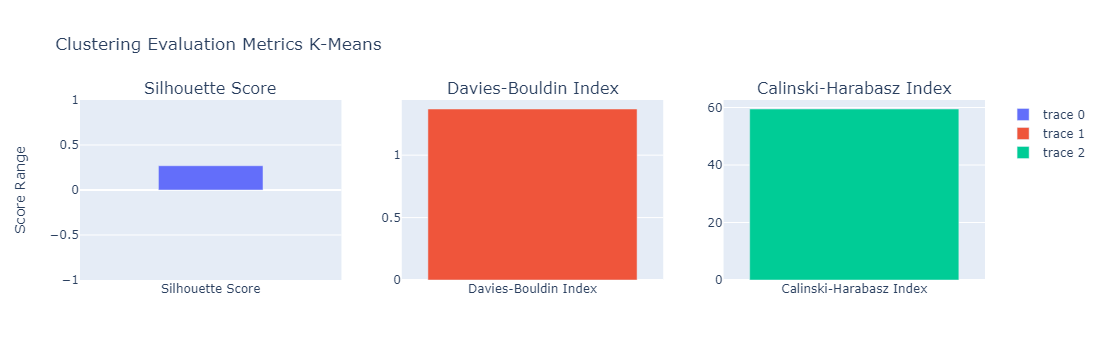

In [42]:
fig = make_subplots(rows=1, cols=3, subplot_titles=['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'])

fig.add_trace(go.Bar(x=['Silhouette Score'], y=[silhouette_avg_kmeans]), row=1, col=1)
fig.add_trace(go.Bar(x=['Davies-Bouldin Index'], y=[db_index_kmeans]), row=1, col=2)
fig.add_trace(go.Bar(x=['Calinski-Harabasz Index'], y=[ch_index_kmeans]), row=1, col=3)
fig.update_yaxes(range=[-1, 1], title_text='Score Range', row=1, col=1)
fig.update_xaxes(range=[-1, 1], row=1, col=1)
fig.update_layout(title='Clustering Evaluation Metrics K-Means')
fig.show()

# Second Approach

# Similarity Search

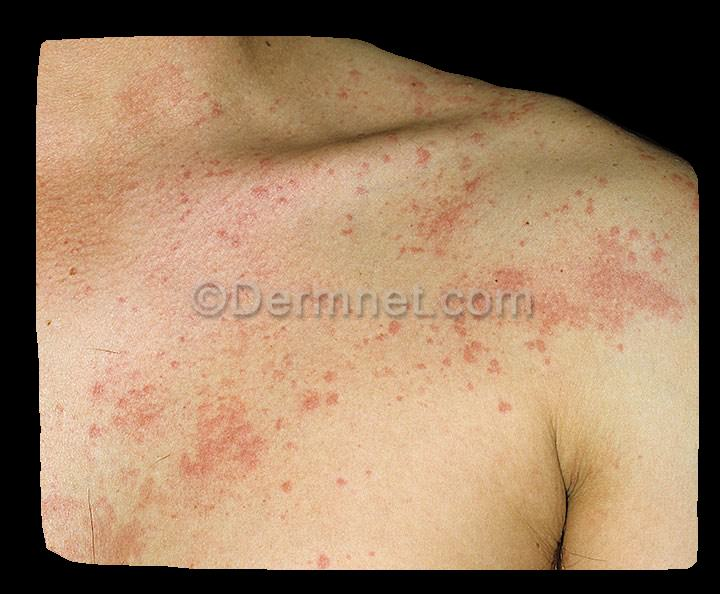

In [44]:
from IPython.display import Image, display

#Example Image index 3
# Display the image
image_to_visualize =  "C:\\Users\\14385\\Desktop\\MaskRCNN'\\segmented_Dermnet_cholinergic-uriticaria-1.jpg"   #17- chrolinegic
#"C:\\Users\\14385\\Desktop\\MaskRCNN'\\segmented_DermnetNZ_Cold01.png.jpg"  #31 - cold
#"C:\\Users\\14385\\Desktop\\MaskRCNN'\\segmented_angioedema-0016__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg" 
#"C:\\Users\\14385\\Desktop\\MaskRCNN'\\segmented_angioedema-0011__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg" #3 - angioedeme
# 

display(Image(filename=image_to_visualize))


Filename: segmented_DermnetNZ_Pressure02.png.jpg


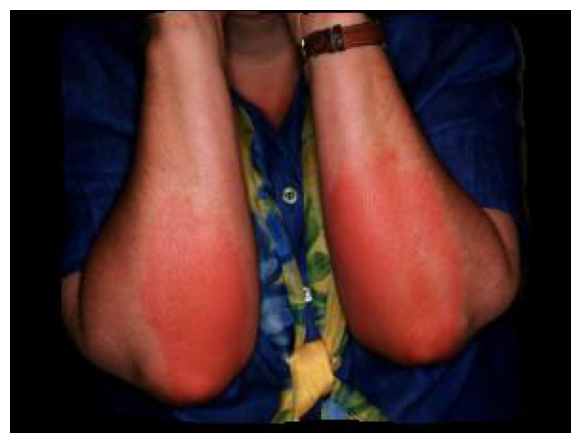

Filename: segmented_Urticaria_Sofia_09.png.jpg


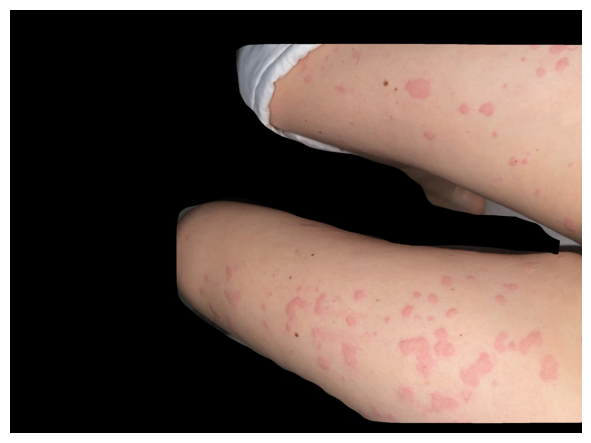

Filename: segmented_AllergyK_Vibratory02.png.png


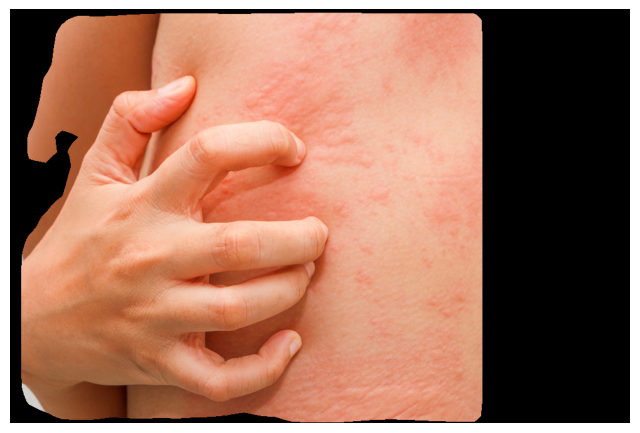

Filename: segmented_angioedema-0011__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg


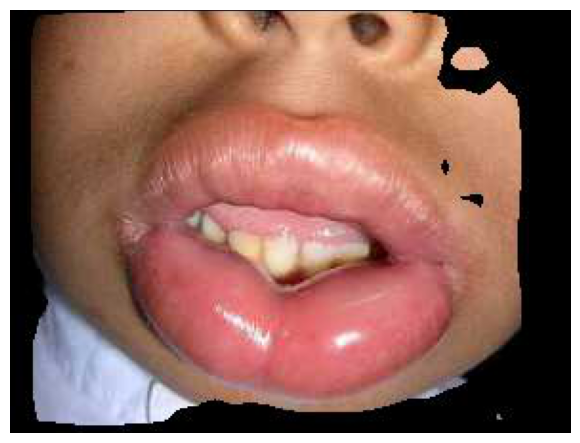

Filename: segmented_DermnetNZ_Urticaria_Unlabeled13.png.jpg


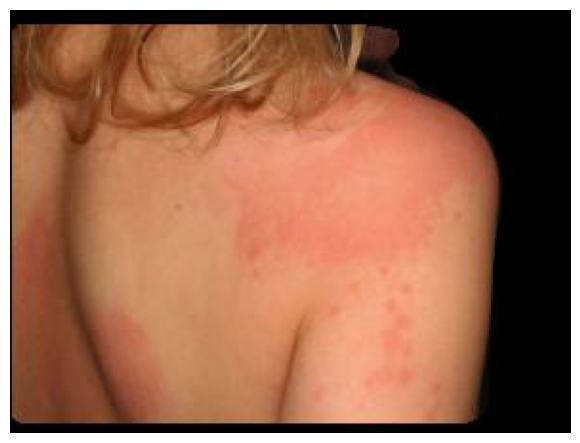

Filename: segmented_Urticaria_Sofia_06.png.png


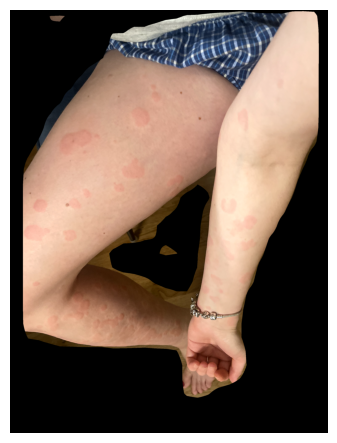

Filename: segmented_Dermnet_angioedema-3.jpg


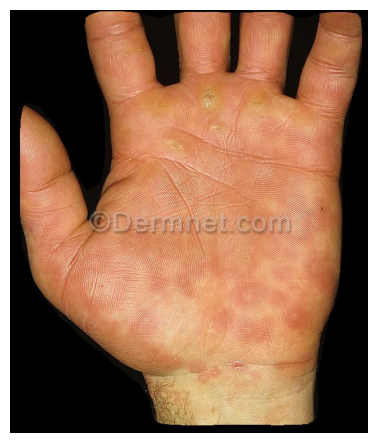

Filename: segmented_DermnetNZ_Pressure03.png.jpg


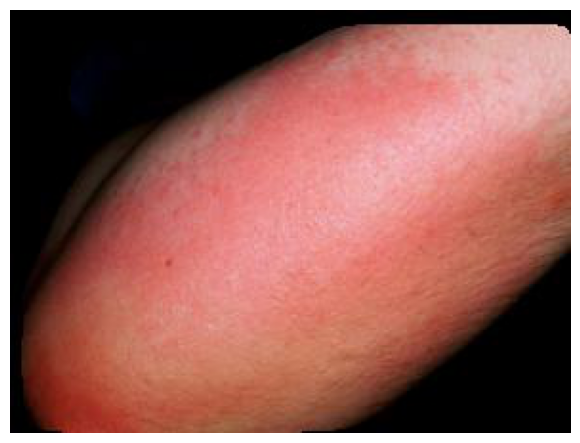

Filename: segmented_angioedema-0016__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg


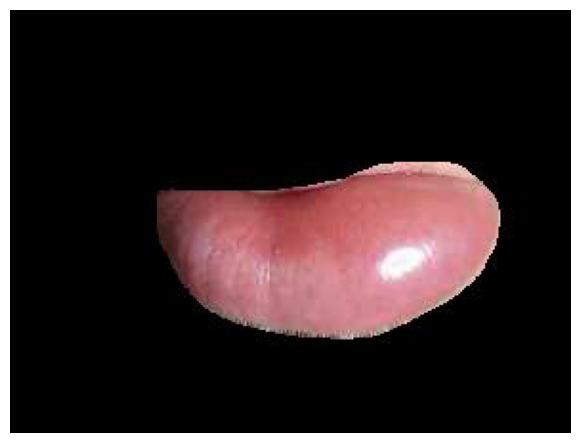

Filename: segmented_DermnetNZ_Aguagenic01.png.jpg


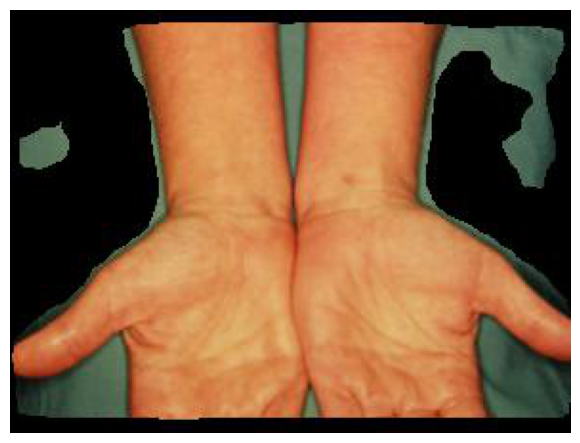

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
query_image_index = 39

# Get the feature vector for the query image
query_features = reduced_features[query_image_index].reshape(1, -1)

# Calculate cosine similarity between the query image and all other images
similarity_scores = cosine_similarity(query_features, reduced_features)

# Get the indices of images sorted by similarity (excluding the query image itself)
sorted_indices = similarity_scores.argsort()[0][::-1][1:]

# Print the indices of the top similar images
top_similar_indices = sorted_indices[:10] 

# Print the indices and display the images of the top similar images
for index in top_similar_indices:
    filename = all_files[index]
    filepath = os.path.join(data_dir, filename)

    # Print the filename
    print("Filename:", filename)

    # Display the image
    image = Image.open(filepath)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [47]:
import pandas as pd

# Initialize a list to store information about similar images
similar_images_info = []

# Iterate over the top similar indices
for index in top_similar_indices:
    filename_1 = all_files[index]
    filepath_1 = os.path.join(data_dir, filename)

    # Append information to the list
    similar_images_info.append({
        'Filename': filename_1,
        'Filepath': filepath_1,
        'Similarity Score': similarity_scores[0, index]  # Add similarity score if needed
    })

# Create a DataFrame from the list
similar_images_df = pd.DataFrame(similar_images_info)

# Display the DataFrame
display(similar_images_df)


Filename  \
0             segmented_DermnetNZ_Pressure02.png.jpg   
1               segmented_Urticaria_Sofia_09.png.jpg   
2             segmented_AllergyK_Vibratory02.png.png   
3  segmented_angioedema-0011__ProtectWyJQcm90ZWN0...   
4  segmented_DermnetNZ_Urticaria_Unlabeled13.png.jpg   
5               segmented_Urticaria_Sofia_06.png.png   
6                 segmented_Dermnet_angioedema-3.jpg   
7             segmented_DermnetNZ_Pressure03.png.jpg   
8  segmented_angioedema-0016__ProtectWyJQcm90ZWN0...   
9            segmented_DermnetNZ_Aguagenic01.png.jpg   

                                            Filepath  Similarity Score  
0  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.948008  
1  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.919182  
2  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.912879  
3  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.887528  
4  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.853745  
5  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.830135  
6  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.787371  
7  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.770130  
8  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.755699  
9  C:\Users\14385\Desktop\MaskRCNN'\segmented_Der...          0.748347

In [ ]:
all_files[17]

In [ ]:
print(f"Silhouette Score K-Means: {silhouette_avg_kmeans}")
db_index_kmeans = davies_bouldin_score(reduced_features, kmeans_cluster_labels)
ch_index_kmeans = calinski_harabasz_score(reduced_features, kmeans_cluster_labels)




In [ ]:
# Create a DataFrame
final_metrics_df = pd.DataFrame({
    'Metric': ['Silhouette Score K-Means', 'Davies-Bouldin Index K-Means', 'Calinski-Harabasz Index K-Means'],
    'Value': [silhouette_avg_kmeans, db_index_kmeans, ch_index_kmeans]
})

# Display the DataFrame
display(final_metrics_df)